In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline 

In [2]:
def get_mnist_data():
    df = pd.read_csv('../data/mnist/train.csv',header=None)
    data = df.iloc[1:].as_matrix()
    data = data.astype('int')
    Y = data[:,0]
    X = data[:,1:]/255.0
    return X,Y

In [3]:
X,Y = get_mnist_data()
print 'finish loading data'

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

finish loading data


In [4]:
def display_sample_image(X,Y):
    labels = ["0","1","2","3","4","5","6","7","8","9"]
    X, Y = shuffle(X,Y)
    for i in xrange(12):
        plt.subplot(3,4,i)
        img = X[i].reshape(28,28)
        plt.imshow(img,cmap='gray')
        plt.axis("off")
        plt.title(labels[Y[i]])
    plt.show()

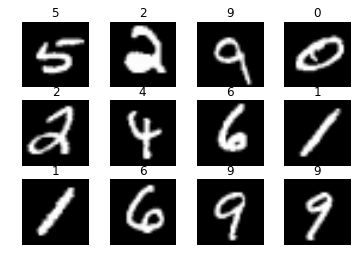

In [5]:
display_sample_image(X,Y)

In [6]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1,keepdims=True)

In [7]:
def cost(T,Y):
    return -(T*np.log(Y)).sum()

In [8]:
def y2indicator(Y):
    N = Y.shape[0]
    K = len(set(Y))
    Y_ind = np.zeros((N,K))
    for i in xrange(N):
        Y_ind[i,Y[i]] = 1
    return Y_ind

In [9]:
def error_rate(targets,predictions):
    return np.mean(targets != predictions)

In [10]:
def relu(x):
    return x*(x>0)

In [11]:
def derivative_w2(Z,T,Y):
    return Z.T.dot(T-Y)
def derivative_b2(T,Y):
    return (T-Y).sum(axis=0)
def derivative_w1(X, Z, T, Y, W2):
#     return X.T.dot((T-Y).dot(W2.T)*Z*(1-Z))
    return X.T.dot((T-Y).dot(W2.T)*(Z>0))
def derivative_b1(Z, T, Y, W2):
#     return ((T-Y).dot(W2.T)*Z*(1-Z)).sum(axis=0)
    return ((T-Y).dot(W2.T)*(Z>0)).sum(axis=0)

In [54]:
class NN(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-6,reg=1e-6,epochs=10000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 5
        self.W1 = np.random.randn(D,M) / np.sqrt(D+M)
        self.b1 = np.zeros(M)
        self.W2 = np.random.randn(M,K) / np.sqrt(M+K)
        self.b2 = np.zeros(K)
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            P_Y_train, hidden = self.forward(X_train)
            self.W2 += learning_rate*(derivative_w2(hidden,T_train_ind,P_Y_train) + reg*self.W2)
            self.b2 += learning_rate*(derivative_b2(T_train_ind,P_Y_train) + reg*self.b2)
            self.W1 += learning_rate*(derivative_w1(X_train,hidden,T_train_ind,P_Y_train,self.W2)
                                      + reg*self.W1)
            self.b1 += learning_rate*(derivative_b1(hidden,T_train_ind,P_Y_train,self.W2) + 
                                      reg*self.b1)
            if epoch % 1000 == 0:
                P_Y_valid, _ = self.forward(X_valid)
                c = cost(T_valid_ind,P_Y_valid)
                costs.append(c)
                e = error_rate(T_valid,np.argmax(P_Y_valid,axis=1))
                print "epoch: ",epoch, "cost: ",c, "error: ", e
            if e < best_validation_error:
                best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def forward(self,X):
        hidden = relu(X.dot(self.W1) + self.b1)
        A = hidden.dot(self.W2) + self.b2
        expA = np.exp(A)
        Y = expA / expA.sum(axis=1,keepdims=True)
        return Y, hidden 
    def predict(self,X):
        P_Y,_ = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

epoch:  0 cost:  2328.79880363 error:  0.909
epoch:  1000 cost:  725.197199055 error:  0.224
epoch:  2000 cost:  625.391977689 error:  0.202
epoch:  3000 cost:  580.108348701 error:  0.189
epoch:  4000 cost:  558.960828004 error:  0.182
epoch:  5000 cost:  546.044594548 error:  0.175
epoch:  6000 cost:  536.74568018 error:  0.169
epoch:  7000 cost:  530.299880866 error:  0.17
epoch:  8000 cost:  525.363997879 error:  0.165
epoch:  9000 cost:  521.626876467 error:  0.162
best validation error:  0.162


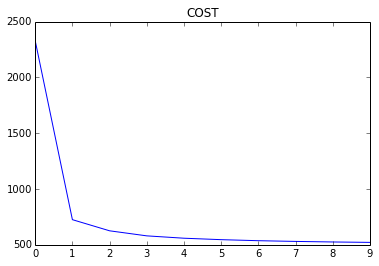

In [55]:
nn_classifier = NN()
nn_classifier.train(X,Y)

## Performing the cross validation for hyperparameter selection

In [47]:
def cross_validation(model,X,Y,lr,reg,k_fold=5):
    fold_size = len(Y)/k_fold
    X, Y = shuffle(X, Y)
    scores = []
    for k in xrange(k_fold):
        X_train = np.concatenate([X[:k*fold_size,:],X[:k*fold_size + fold_size,:]])
        Y_train = np.concatenate([Y[:k*fold_size],Y[:k*fold_size + fold_size]])
        X_test = X[k*fold_size:k*fold_size+fold_size]
        Y_test = Y[k*fold_size:k*fold_size+fold_size]
        model.train(X_train,Y_train,learning_rate=lr,reg=reg,show_fig=False)
        score = model.score(X_test,Y_test)
        scores.append(score)
    return np.mean(scores), model

In [48]:
learning_rates = [10e-8, 10e-7,10e-6,10e-5,10e-4]
regularization_strengths = [10e-12,10e-11,10e-10,10e-9,10e-8,10e-7]
results = {}
best_score = -1   # The highest validation accuracy that we have seen so far.
for lr in learning_rates:
    for rg in regularization_strengths:
        print "############testing on model with lr:",lr,"reg:",rg," ###########"
        model = NN()
        test_score, model = cross_validation(model,X,Y,lr,rg)
        results[(lr,rg)] = test_score
        if test_score > best_score:
            best_score = test_score
for lr, rg in sorted(results):
    test_score = results[(lr, rg)]
    print 'lr %e reg %e test score: %f' % (lr, rg, test_score)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_score


############testing on model with lr: 1e-07 reg: 1e-11  ###########
epoch:  0 cost:  2304.84735846 error:  0.93
epoch:  100 cost:  2290.4601953 error:  0.922
epoch:  200 cost:  2279.07363149 error:  0.908
epoch:  300 cost:  2269.02765123 error:  0.893
epoch:  400 cost:  2258.64127135 error:  0.879
epoch:  500 cost:  2247.58944666 error:  0.87
epoch:  600 cost:  2236.483928 error:  0.853
epoch:  700 cost:  2225.41886096 error:  0.84
epoch:  800 cost:  2214.52031195 error:  0.832
epoch:  900 cost:  2203.73280526 error:  0.819
best validation error:  0.819
epoch:  0 cost:  2302.99978385 error:  0.884
epoch:  100 cost:  2265.42958505 error:  0.839
epoch:  200 cost:  2238.10356937 error:  0.832
epoch:  300 cost:  2214.1031652 error:  0.822
epoch:  400 cost:  2191.20237814 error:  0.815
epoch:  500 cost:  2168.83391013 error:  0.81
epoch:  600 cost:  2146.46882105 error:  0.799
epoch:  700 cost:  2123.13864641 error:  0.785
epoch:  800 cost:  2098.06795732 error:  0.765
epoch:  900 cost:  20

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: overflow encountered in exp
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


best validation error:  0.145
epoch:  0 cost:  2237.36968301 error:  0.791
epoch:  100 cost:  nan error:  0.9
epoch:  200 cost:  nan error:  0.9
epoch:  300 cost:  nan error:  0.9
epoch:  400 cost:  nan error:  0.9
epoch:  500 cost:  nan error:  0.9
epoch:  600 cost:  nan error:  0.9
epoch:  700 cost:  nan error:  0.9
epoch:  800 cost:  nan error:  0.9
epoch:  900 cost:  nan error:  0.9
best validation error:  0.791
epoch:  0 cost:  2249.58394076 error:  0.786
epoch:  100 cost:  nan error:  0.902
epoch:  200 cost:  nan error:  0.902
epoch:  300 cost:  nan error:  0.902
epoch:  400 cost:  nan error:  0.902
epoch:  500 cost:  nan error:  0.902
epoch:  600 cost:  nan error:  0.902
epoch:  700 cost:  nan error:  0.902
epoch:  800 cost:  nan error:  0.902
epoch:  900 cost:  nan error:  0.902
best validation error:  0.786
epoch:  0 cost:  2277.87795727 error:  0.925
epoch:  100 cost:  nan error:  0.916
epoch:  200 cost:  nan error:  0.916
epoch:  300 cost:  nan error:  0.916
epoch:  400 cost

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


epoch:  0 cost:  nan error:  0.904
epoch:  100 cost:  nan error:  0.895
epoch:  200 cost:  nan error:  0.895
epoch:  300 cost:  nan error:  0.895
epoch:  400 cost:  nan error:  0.895
epoch:  500 cost:  nan error:  0.895
epoch:  600 cost:  nan error:  0.895
epoch:  700 cost:  nan error:  0.895
epoch:  800 cost:  nan error:  0.895
epoch:  900 cost:  nan error:  0.895
best validation error:  0.895
epoch:  0 cost:  nan error:  0.903
epoch:  100 cost:  nan error:  0.903
epoch:  200 cost:  nan error:  0.903
epoch:  300 cost:  nan error:  0.903
epoch:  400 cost:  nan error:  0.903
epoch:  500 cost:  nan error:  0.903
epoch:  600 cost:  nan error:  0.903
epoch:  700 cost:  nan error:  0.903
epoch:  800 cost:  nan error:  0.903
epoch:  900 cost:  nan error:  0.903
best validation error:  0.903
############testing on model with lr: 0.001 reg: 1e-10  ###########
epoch:  0 cost:  5202.43913303 error:  0.889
epoch:  100 cost:  nan error:  0.889
epoch:  200 cost:  nan error:  0.889
epoch:  300 cost: